<a href="https://colab.research.google.com/github/yoheyokubo/AdjustAutocorrelation/blob/master/Data_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/NovoNordisk/
!ls

/content/drive/MyDrive/NovoNordisk
AnomalyDetection_Yohei.ipynb  kaggle.json  kermany2018	kermany2018.zip


# Download the Dataset (only once)

In [6]:
# Follow the link https://www.kaggle.com/discussions/general/74235 and download API key (kaggle.json) from your GitHub
!pip install -q kaggle

In [ ]:
# or manually upload kaggle.json to the current directory
from google.colab import files
files.upload()

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [22]:
# This won't work for me so I used curl command below
!kaggle datasets download -d paultimothymooney/kermany2018 --unzip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/kermany2018
License(s): CC-BY-NC-SA-4.0
^C


In [ ]:
!cat ~/.kaggle/kaggle.json

In [33]:
# please provide your username and API key below
!curl -L -u yoheiokubo:f55084232ed2a33d56fda302c896c339 \
  -o kermany2018.zip \
  https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/kermany2018

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.8G  100 10.8G    0     0  57.0M      0  0:03:14  0:03:14 --:--:-- 55.5M


In [ ]:
# note that it took 1.5 hours in my environment (so manual download and upload may be recommended)
!unzip kermany2018.zip -d ./kermany2018

# Data Distributions

In [ ]:
# reference (the most up-voted notebook): https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch

In [13]:
# run this only once
# %mv "kermany2018/OCT2017 " "kermany2018/OCT2017"

In [60]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch
torch.manual_seed(123)

In [61]:
data_dir = './kermany2018/OCT2017'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

data_transforms = {
    TRAIN: transforms.Compose([
        # Because each image has a different size, we need to resize (e.g., (3, 496, 512) -> (3, 256, 256 * 512/ 496)) and crop ( -> (3, 224, 224))
        transforms.Resize(256),
        transforms.CenterCrop(224), # In stead of resize and crop, we can use data augmentation in the TRAIN only: transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle= (x == TRAIN), num_workers=2
    )
    for x in [TRAIN, VAL, TEST]
}

In [62]:
# attribute discriptions
print('classes: ', image_datasets[TRAIN].classes)
print('class_to_index: ', image_datasets[TRAIN].class_to_idx)
print('all images (path, label): ', image_datasets[TRAIN].imgs[:2])
print('all images (data, label): ', image_datasets[TRAIN][0][0].shape, image_datasets[TRAIN][0][1])
print('labels: ', image_datasets[TRAIN].targets[:2])

classes:  ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_to_index:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
all images (path, label):  [('./kermany2018/OCT2017/train/CNV/CNV-1016042-1.jpeg', 0), ('./kermany2018/OCT2017/train/CNV/CNV-1016042-10.jpeg', 0)]
all images (data, label):  torch.Size([3, 224, 224]) 0
labels:  [0, 0]


In [63]:
class_names = image_datasets[TRAIN].classes
for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(len(image_datasets[x]), x))
    cnt_dict = {}
    for class_name in class_names:
      cnt = (np.array(image_datasets[x].targets) == image_datasets[x].class_to_idx[class_name]).astype(int).sum().item() # count the number of samples in the class
      cnt_dict[class_name] = cnt
    print('  count: ', cnt_dict, '  ratio: ', {k:v/cnt_dict['CNV'] for k, v in cnt_dict.items()})

Loaded 83484 images under train
  count:  {'CNV': 37205, 'DME': 11348, 'DRUSEN': 8616, 'NORMAL': 26315}   ratio:  {'CNV': 1.0, 'DME': 0.30501276710119607, 'DRUSEN': 0.23158177664292434, 'NORMAL': 0.7072974062625991}
Loaded 32 images under val
  count:  {'CNV': 8, 'DME': 8, 'DRUSEN': 8, 'NORMAL': 8}   ratio:  {'CNV': 1.0, 'DME': 1.0, 'DRUSEN': 1.0, 'NORMAL': 1.0}
Loaded 968 images under test
  count:  {'CNV': 242, 'DME': 242, 'DRUSEN': 242, 'NORMAL': 242}   ratio:  {'CNV': 1.0, 'DME': 1.0, 'DRUSEN': 1.0, 'NORMAL': 1.0}


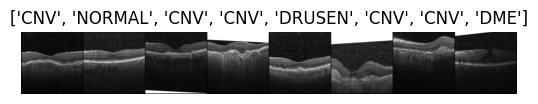

In [69]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # imshow() expects image shape as (H, W, C)
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs) # (B, C, H, W) -> (C, H_total, W_total) suitable for plotting.
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)